In [6]:
from tools_harassment import * 
from models import *
from transformer_class import *
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences
import os 
import torch 
import gc
import pandas as pd

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

path="../../../Datasets/CSV_Harassment/"
train =pd.read_csv(path + "train_format.csv")
val=pd.read_csv(path + "val_format.csv")
test=pd.read_csv(path + "test_format.csv")

keys=["NonH", "IndirectH", "PhysicalH", "SexualH"]

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl


embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../../../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


(1193513, 200)

In [7]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def data_gen(batch_size, mode, x_train, lab_str_embeddings, index_embeddings): 
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=x_train.shape[0]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        objs=ids_train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=x_val.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0] for x in x_list]   
        objs=val['tweet_id']    #df_val['Unnamed: 0'].values        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels)  
    if mode=='Test':
        max_objs=x_test.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0]+x_val.shape[0] for x in x_list]
        total=x_train.shape[0]+x_val.shape[0]
        objs=test['tweet_id']  
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------  
    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        temp=[]
        for pos in batch:
            temp2=[index_embeddings[pos+5]]  
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    #print ("primer batch X.Y", new_x_data[0], y_data[0])
    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
            

def make_model_concat(target, K_list_new, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            #print ("BATCH\n", i, '\n', batch.src)
            out = model.forward(batch.src, batch.src_mask)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=cm_norma(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ": %.3f" % acc_t)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma_t)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [8]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
    
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= np.asarray([1.0, 1.0, 1.0, 1.0])
print ("Pesos de clases:", class_weights)

ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

Pesos de clases: [1. 1. 1. 1.]


In [9]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [10]:
path_m='../../../Datasets/Models_Harassment/'

etiq=np.asarray(labels_train)
etiq_v=np.asarray(labels_val)
etiq_t=np.asarray(labels_test)

In [11]:
    
class SimpleLossComputeFL:
    "A simple loss compute and train function."
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, mode):
        y_new=(y.float()-torch.ones((y.shape))).int() 
        ac=accuracy_scorer(x, y_new)
        f1=f_scorer(x, y_new)
        cm=compute_confusion_matrix(x, y_new)
        tempa= x.contiguous().view(-1, x.size(-1))
        tempb= y_new.long().contiguous().view(-1)
        loss = self.criterion(tempa, tempb) #/ norm
        if mode!='Test':
            loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()    
        return [loss.data, ac ,f1, cm] #*norm #[0] * norm
        # loss.data[0] * norm

In [12]:
from bert_serving.client import BertClient
import seaborn 

def draw(data, ax, label, color="Blues"):
    seaborn.heatmap(data, 
                    xticklabels=label[0], square=True, yticklabels=label[0], vmin=0.0, vmax=1.0, 
                    cbar=False,  cmap=color, ax=ax)

#sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
#                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
#    plt.show()
    
bc = BertClient()  

In [13]:
n_machines=5

In [14]:
path_a='../../../Datasets/CSV_Harassment/Aumento_ofi/' 

In [15]:
def train_transformer(prob, num_epochs, path_a, path_m, c_gama, class_weights=np.ones(4), xfrom=1, xto=20, x_train=x_train, sentences=sentences, labels_train=labels_train, augmented=False):    
    global_accs=[]
    global_fnones=[]
    global_fmacros=[]
    global_cms=[]
    global_attn=[]
    best_macro={'F_ma':0.1 , 'Run':0}

    bs=32
    if augmented:
        tope=11218
    else:
        tope=4520
    for x in range(xfrom, xto + 1):
        if augmented:
            macro_augmented= np.load(path_a + 'balance_GloVe_' + str(int(prob*100)) + '_'+ str(x)+'_run.npy', allow_pickle=True)
            ids_train=macro_augmented[:,0]
            tws_train=macro_augmented[:,1]
            labels_train=macro_augmented[:,2]
            class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
            print ("Pesos de clases:", class_weights)

            etiq=np.asarray(labels_train)
            sentences = tws_train
            n_labels = etiq.copy()
            y_train=to_categorical(n_labels,num_classes=4)

            input_ids=[]
            for sent in sentences:
                encoded_sent=[]
                for wd in sent:
                    try:
                        encoded_sent.append(token_2_idx[wd])
                    except:
                        continue
                input_ids.append(encoded_sent)

            input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
            shape=np.asarray(input_ids).shape

            x_train=np.zeros((shape[0], shape[1], emb))
            j=0
            for in_id in input_ids:
                x_train[j]=EMB_matrix[in_id]
                j+=1

        ################################################    
        print ("Entrenando Run #", x)
        
        b_dim=768
        espacio=[np.ones(b_dim)]
        Ks= ortho_group.rvs(dim=b_dim)
        random=np.random.randint(Ks.shape[0], size=4)
        K_list=Ks[random]
        K_list_ext=espacio+list(K_list)
        index_embeddings=[0,1,2,3,4]
        lab_str_embeddings=['','','','','']
        
        if augmented:
            for i in range(len(sentences)):
                tw_tr=sentences[i]
                clase=dict_cl[labels_train[i]]            
                tw=' '.join([word for word in tw_tr])
                vector= bc.encode([tw])[0]
                final_bert= vector

                index_embeddings.append(i+5)
                lab_str_embeddings.append(clase)
                K_list_ext.append(final_bert) 
        
        else:
            for i in range(len(sentences)):
                tw_tr=sentences[i]
                clase=dict_cl[labels_train[i]]            
                encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
                vector=bc.encode([encoded_tok])[0]
                final_bert= vector

                index_embeddings.append(i+5)
                lab_str_embeddings.append(clase)
                K_list_ext.append(final_bert)

        objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
        objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
        lab_val=val['Label']
        lab_test=test['Label']
        tw_val=val['Tweet']
        tw_test=test['Tweet']
        llaves=np.concatenate([objs_val,objs_test])
        clases=np.concatenate([lab_val,lab_test])
        sent_all=np.concatenate([tw_val,tw_test])   
        
        for num in range(len(llaves)):
            i=llaves[num]
            clase=clases[num]
            tw_tr=sent_all[num]
            encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
            vector=bc.encode([encoded_tok])[0]
            final_bert= vector

            index_embeddings.append(num+5+train.shape[0])
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)


        K_list_new= np.asarray(K_list_ext, dtype='float32')

        ###################################### TRANSFORMER ###############################
        hist_train_loss=[]
        hist_train_acc=[]
        hist_train_fma=[]
        hist_val_loss=[]
        hist_val_acc=[]
        hist_val_fma=[]

        V = 4
        pesos = torch.from_numpy(class_weights).float()
        criterion = FocalLoss(weights=pesos)
        model = make_model_concat(4, K_list_new, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
        model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))


        for epoch in range(num_epochs):
            model.train()
            DATA=data_gen(bs, 'Train', x_train, lab_str_embeddings, index_embeddings)  
            loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')

            model.eval()
            DATA_VAL=data_gen(bs, 'Val', x_train, lab_str_embeddings, index_embeddings)
            loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(DATA_VAL, model, SimpleLossComputeFL(criterion, None),'Val')
            if epoch%10==0:
                print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())

        model.eval()
        print ("Testing run #",x)
        DATA_TEST=data_gen(bs, 'Test', x_train, lab_str_embeddings, index_embeddings)
        predicciones = run_epoch(DATA_TEST, model, SimpleLossComputeFL(criterion, None),'Test')
        predicciones=np.concatenate(predicciones, axis=-1)

        glo_acc=accuracy_score(etiq_t, predicciones[:-21])
        glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
        glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

        glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

        plot_cm(cm_norma(glo_cm),["NonH", "IndirectH", "PhysicalH", "SexualH"],"BERT Transformer ", cmap=c_gama)
        global_accs.append(glo_acc)
        global_fnones.append(glo_fno)
        global_fmacros.append(glo_fma)
        global_cms.append(glo_cm)
        print("Test_ acc:",glo_acc) 
        print("Test_ f1 none:",glo_fno) 
        print("Test_ f1 macro:",glo_fma) 

        if glo_fma>best_macro['F_ma']:
            best_macro['F_ma']=glo_fma
            best_macro['Run']=x                
            print ("\n\nNuevo best encontrado:\n")
            print ("Acc: %.3f" % glo_acc, "\tF1-ma: %.3f" % glo_fma)
            np.set_printoptions(precision=3)
            print ("\tF1-none: ", glo_fno)
                    
    return best_macro, global_accs, global_fnones, global_fmacros, global_cms

Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.273 	F-macro_val: 0.167
Epoch 10 	acc_val: 0.679 	F-macro_val: 0.216
Epoch 20 	acc_val: 0.694 	F-macro_val: 0.220
Epoch 30 	acc_val: 0.707 	F-macro_val: 0.231
Epoch 40 	acc_val: 0.714 	F-macro_val: 0.234
Epoch 50 	acc_val: 0.707 	F-macro_val: 0.235
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


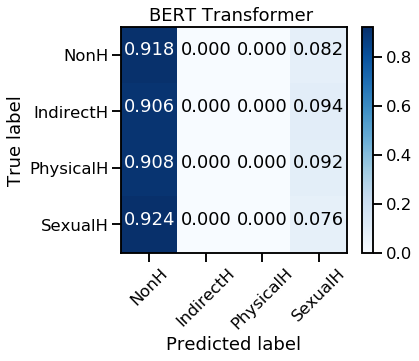

Test_ acc: 0.7041921808761187
Test_ f1 none: [0.82783883 0.         0.         0.10097087]
Test_ f1 macro: 0.23220242540630892


Nuevo best encontrado:

Acc: 0.704 	F1-ma: 0.232
	F1-none:  [0.828 0.    0.    0.101]
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.159
Epoch 10 	acc_val: 0.678 	F-macro_val: 0.217
Epoch 20 	acc_val: 0.689 	F-macro_val: 0.230
Epoch 30 	acc_val: 0.688 	F-macro_val: 0.240
Epoch 40 	acc_val: 0.700 	F-macro_val: 0.230
Epoch 50 	acc_val: 0.700 	F-macro_val: 0.226
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


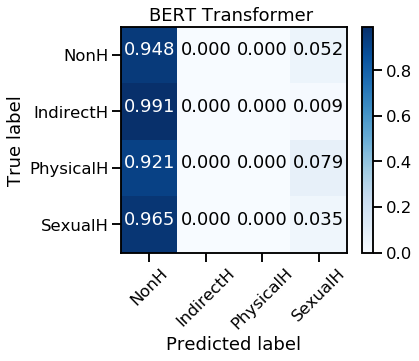

Test_ acc: 0.7206782854451248
Test_ f1 none: [0.838 0.    0.    0.054]
Test_ f1 macro: 0.2231273939300054
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.195 	F-macro_val: 0.134
Epoch 10 	acc_val: 0.679 	F-macro_val: 0.216
Epoch 20 	acc_val: 0.699 	F-macro_val: 0.231
Epoch 30 	acc_val: 0.686 	F-macro_val: 0.240
Epoch 40 	acc_val: 0.702 	F-macro_val: 0.244
Epoch 50 	acc_val: 0.700 	F-macro_val: 0.243
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


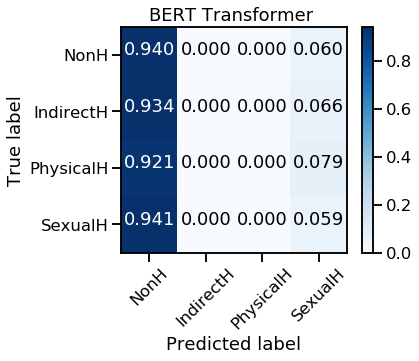

Test_ acc: 0.7183231276495525
Test_ f1 none: [0.837 0.    0.    0.085]
Test_ f1 macro: 0.23064045953423823
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.284 	F-macro_val: 0.176
Epoch 10 	acc_val: 0.676 	F-macro_val: 0.216
Epoch 20 	acc_val: 0.692 	F-macro_val: 0.234
Epoch 30 	acc_val: 0.688 	F-macro_val: 0.227
Epoch 40 	acc_val: 0.701 	F-macro_val: 0.235
Epoch 50 	acc_val: 0.708 	F-macro_val: 0.232
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


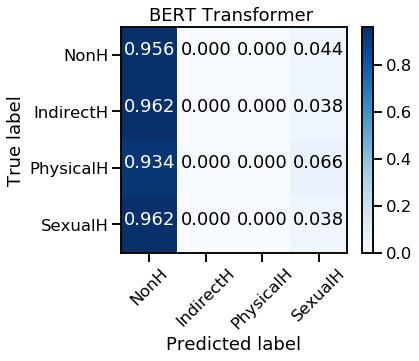

Test_ acc: 0.7268016957136129
Test_ f1 none: [0.843 0.    0.    0.06 ]
Test_ f1 macro: 0.2256973088423207
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.275 	F-macro_val: 0.170
Epoch 10 	acc_val: 0.675 	F-macro_val: 0.223
Epoch 20 	acc_val: 0.691 	F-macro_val: 0.227
Epoch 30 	acc_val: 0.696 	F-macro_val: 0.229
Epoch 40 	acc_val: 0.698 	F-macro_val: 0.240
Epoch 50 	acc_val: 0.695 	F-macro_val: 0.231
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


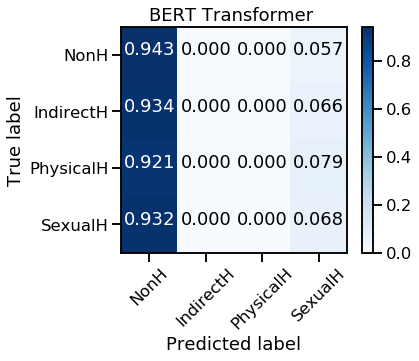

Test_ acc: 0.7216203485633538
Test_ f1 none: [0.839 0.    0.    0.098]
Test_ f1 macro: 0.23438911230902335


Nuevo best encontrado:

Acc: 0.722 	F1-ma: 0.234
	F1-none:  [0.839 0.    0.    0.098]
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.301 	F-macro_val: 0.179
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.219
Epoch 20 	acc_val: 0.685 	F-macro_val: 0.228
Epoch 30 	acc_val: 0.696 	F-macro_val: 0.220
Epoch 40 	acc_val: 0.692 	F-macro_val: 0.230
Epoch 50 	acc_val: 0.698 	F-macro_val: 0.236
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


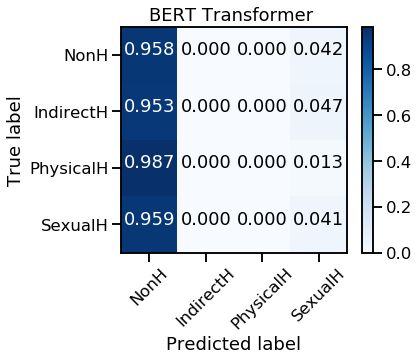

Test_ acc: 0.7291568535091851
Test_ f1 none: [0.844 0.    0.    0.066]
Test_ f1 macro: 0.22728153720639868
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.299 	F-macro_val: 0.177
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.220
Epoch 20 	acc_val: 0.695 	F-macro_val: 0.226
Epoch 30 	acc_val: 0.700 	F-macro_val: 0.243
Epoch 40 	acc_val: 0.703 	F-macro_val: 0.232
Epoch 50 	acc_val: 0.700 	F-macro_val: 0.229
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


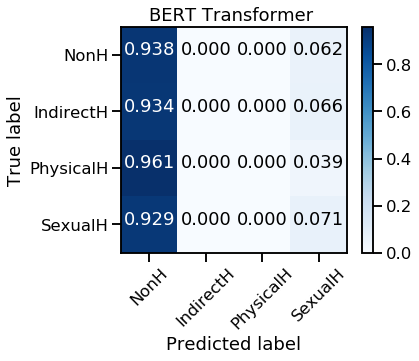

Test_ acc: 0.7183231276495525
Test_ f1 none: [0.836 0.    0.    0.101]
Test_ f1 macro: 0.23436938048728886
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.270 	F-macro_val: 0.174
Epoch 10 	acc_val: 0.667 	F-macro_val: 0.221
Epoch 20 	acc_val: 0.689 	F-macro_val: 0.232
Epoch 30 	acc_val: 0.706 	F-macro_val: 0.234
Epoch 40 	acc_val: 0.707 	F-macro_val: 0.239
Epoch 50 	acc_val: 0.714 	F-macro_val: 0.230
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


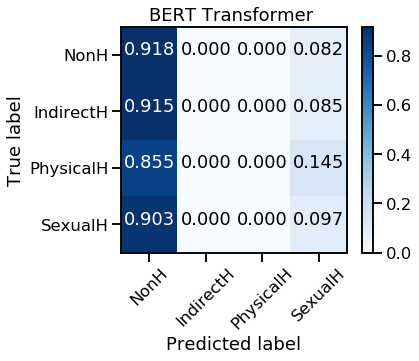

Test_ acc: 0.7079604333490344
Test_ f1 none: [0.831 0.    0.    0.126]
Test_ f1 macro: 0.2391156682623884


Nuevo best encontrado:

Acc: 0.708 	F1-ma: 0.239
	F1-none:  [0.831 0.    0.    0.126]
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.293 	F-macro_val: 0.164
Epoch 10 	acc_val: 0.687 	F-macro_val: 0.213
Epoch 20 	acc_val: 0.693 	F-macro_val: 0.224
Epoch 30 	acc_val: 0.698 	F-macro_val: 0.227
Epoch 40 	acc_val: 0.705 	F-macro_val: 0.238
Epoch 50 	acc_val: 0.703 	F-macro_val: 0.234
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


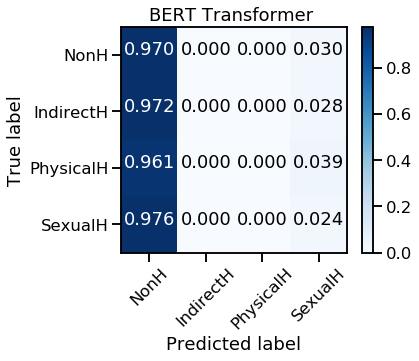

Test_ acc: 0.7352802637776731
Test_ f1 none: [0.848 0.    0.    0.04 ]
Test_ f1 macro: 0.22199284842852912
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.250 	F-macro_val: 0.156
Epoch 10 	acc_val: 0.664 	F-macro_val: 0.207
Epoch 20 	acc_val: 0.689 	F-macro_val: 0.241
Epoch 30 	acc_val: 0.692 	F-macro_val: 0.232
Epoch 40 	acc_val: 0.700 	F-macro_val: 0.226
Epoch 50 	acc_val: 0.700 	F-macro_val: 0.238
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


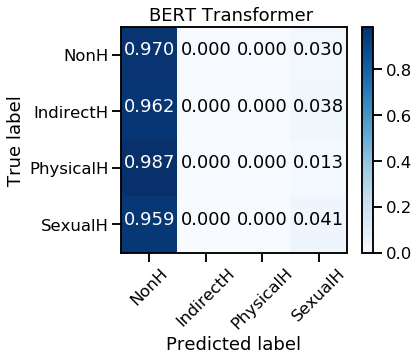

Test_ acc: 0.7381064531323599
Test_ f1 none: [0.849 0.    0.    0.069]
Test_ f1 macro: 0.22953153018780584
Entrenando Run # 11
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.159 	F-macro_val: 0.122
Epoch 10 	acc_val: 0.682 	F-macro_val: 0.215
Epoch 20 	acc_val: 0.695 	F-macro_val: 0.240
Epoch 30 	acc_val: 0.691 	F-macro_val: 0.231
Epoch 40 	acc_val: 0.700 	F-macro_val: 0.243
Epoch 50 	acc_val: 0.701 	F-macro_val: 0.235
Testing run # 11
SE TUVIERON QUE REPETIR 21 EJEMPLOS


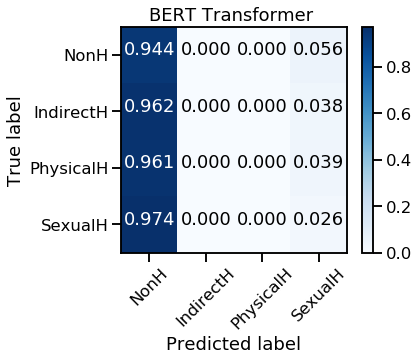

Test_ acc: 0.7164390014130947
Test_ f1 none: [0.836 0.    0.    0.04 ]
Test_ f1 macro: 0.21900984504379195
Entrenando Run # 12
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.233 	F-macro_val: 0.151
Epoch 10 	acc_val: 0.686 	F-macro_val: 0.219
Epoch 20 	acc_val: 0.699 	F-macro_val: 0.232
Epoch 30 	acc_val: 0.708 	F-macro_val: 0.228
Epoch 40 	acc_val: 0.707 	F-macro_val: 0.228
Epoch 50 	acc_val: 0.705 	F-macro_val: 0.244
Testing run # 12
SE TUVIERON QUE REPETIR 21 EJEMPLOS


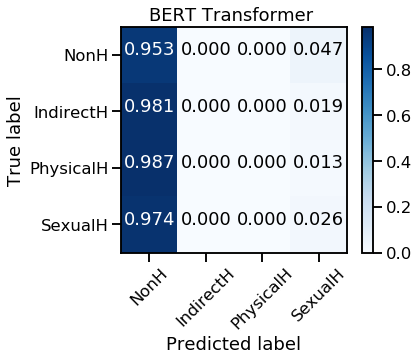

Test_ acc: 0.7225624116815826
Test_ f1 none: [0.839 0.    0.    0.042]
Test_ f1 macro: 0.22022248953867352
Entrenando Run # 13
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.300 	F-macro_val: 0.184
Epoch 10 	acc_val: 0.680 	F-macro_val: 0.211
Epoch 20 	acc_val: 0.688 	F-macro_val: 0.244
Epoch 30 	acc_val: 0.694 	F-macro_val: 0.241
Epoch 40 	acc_val: 0.697 	F-macro_val: 0.241
Epoch 50 	acc_val: 0.699 	F-macro_val: 0.225
Testing run # 13
SE TUVIERON QUE REPETIR 21 EJEMPLOS


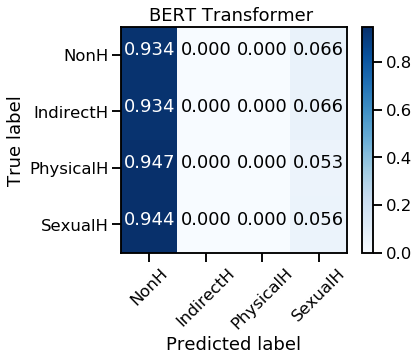

Test_ acc: 0.7131417804992934
Test_ f1 none: [0.833 0.    0.    0.08 ]
Test_ f1 macro: 0.22829131652661067
Entrenando Run # 14
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.195 	F-macro_val: 0.137
Epoch 10 	acc_val: 0.685 	F-macro_val: 0.231
Epoch 20 	acc_val: 0.698 	F-macro_val: 0.230
Epoch 30 	acc_val: 0.706 	F-macro_val: 0.240
Epoch 40 	acc_val: 0.701 	F-macro_val: 0.221
Epoch 50 	acc_val: 0.704 	F-macro_val: 0.248
Testing run # 14
SE TUVIERON QUE REPETIR 21 EJEMPLOS


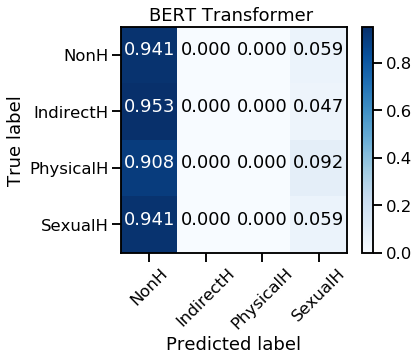

Test_ acc: 0.7192651907677814
Test_ f1 none: [0.838 0.    0.    0.086]
Test_ f1 macro: 0.23088112852395345
Entrenando Run # 15
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.254 	F-macro_val: 0.156
Epoch 10 	acc_val: 0.679 	F-macro_val: 0.218
Epoch 20 	acc_val: 0.693 	F-macro_val: 0.243
Epoch 30 	acc_val: 0.682 	F-macro_val: 0.238
Epoch 40 	acc_val: 0.699 	F-macro_val: 0.224
Epoch 50 	acc_val: 0.703 	F-macro_val: 0.219
Testing run # 15
SE TUVIERON QUE REPETIR 21 EJEMPLOS


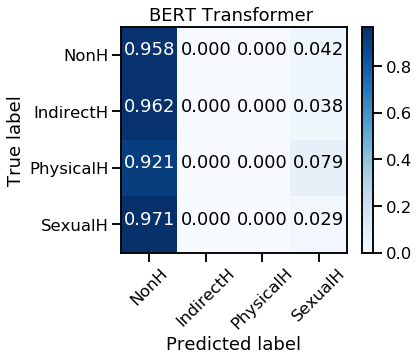

Test_ acc: 0.7268016957136129
Test_ f1 none: [0.843 0.    0.    0.047]
Test_ f1 macro: 0.22249082384874003
Entrenando Run # 16
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.361 	F-macro_val: 0.196
Epoch 10 	acc_val: 0.689 	F-macro_val: 0.218
Epoch 20 	acc_val: 0.702 	F-macro_val: 0.222
Epoch 30 	acc_val: 0.695 	F-macro_val: 0.247
Epoch 40 	acc_val: 0.702 	F-macro_val: 0.237
Epoch 50 	acc_val: 0.696 	F-macro_val: 0.246
Testing run # 16
SE TUVIERON QUE REPETIR 21 EJEMPLOS


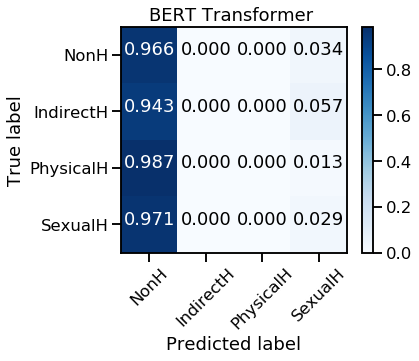

Test_ acc: 0.7329251059821008
Test_ f1 none: [0.847 0.    0.    0.049]
Test_ f1 macro: 0.22380076351301056
Entrenando Run # 17
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.230 	F-macro_val: 0.149
Epoch 10 	acc_val: 0.665 	F-macro_val: 0.219
Epoch 20 	acc_val: 0.691 	F-macro_val: 0.239
Epoch 30 	acc_val: 0.705 	F-macro_val: 0.250
Epoch 40 	acc_val: 0.706 	F-macro_val: 0.243
Epoch 50 	acc_val: 0.712 	F-macro_val: 0.233
Testing run # 17
SE TUVIERON QUE REPETIR 21 EJEMPLOS


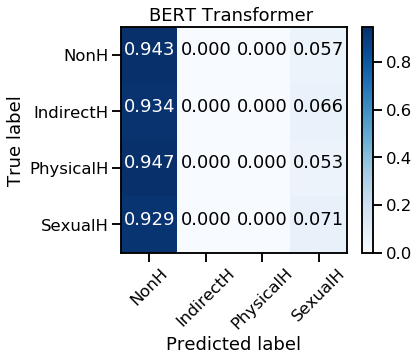

Test_ acc: 0.7225624116815826
Test_ f1 none: [0.839 0.    0.    0.103]
Test_ f1 macro: 0.23558987229433617
Entrenando Run # 18
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.226 	F-macro_val: 0.153
Epoch 10 	acc_val: 0.678 	F-macro_val: 0.220
Epoch 20 	acc_val: 0.695 	F-macro_val: 0.228
Epoch 30 	acc_val: 0.694 	F-macro_val: 0.229
Epoch 40 	acc_val: 0.696 	F-macro_val: 0.240
Epoch 50 	acc_val: 0.700 	F-macro_val: 0.228
Testing run # 18
SE TUVIERON QUE REPETIR 21 EJEMPLOS


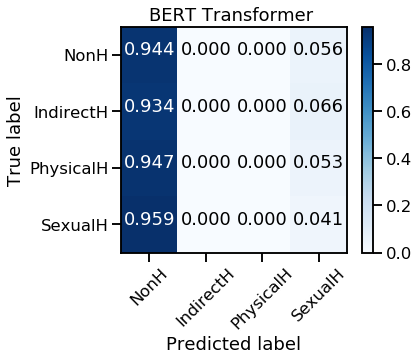

Test_ acc: 0.7183231276495525
Test_ f1 none: [0.837 0.    0.    0.062]
Test_ f1 macro: 0.22472238207899056
Entrenando Run # 19
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.262 	F-macro_val: 0.160
Epoch 10 	acc_val: 0.684 	F-macro_val: 0.213
Epoch 20 	acc_val: 0.689 	F-macro_val: 0.230
Epoch 30 	acc_val: 0.695 	F-macro_val: 0.225
Epoch 40 	acc_val: 0.706 	F-macro_val: 0.232
Epoch 50 	acc_val: 0.705 	F-macro_val: 0.229
Testing run # 19
SE TUVIERON QUE REPETIR 21 EJEMPLOS


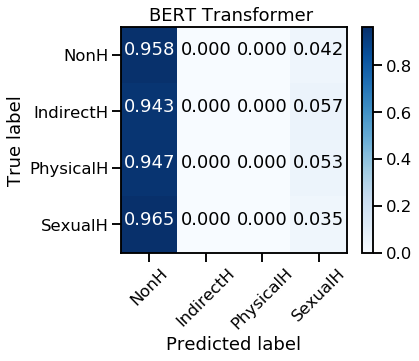

Test_ acc: 0.7282147903909562
Test_ f1 none: [0.844 0.    0.    0.056]
Test_ f1 macro: 0.2249901405334693
Entrenando Run # 20
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.153
Epoch 10 	acc_val: 0.674 	F-macro_val: 0.216
Epoch 20 	acc_val: 0.694 	F-macro_val: 0.235
Epoch 30 	acc_val: 0.701 	F-macro_val: 0.238
Epoch 40 	acc_val: 0.699 	F-macro_val: 0.237
Epoch 50 	acc_val: 0.699 	F-macro_val: 0.227
Testing run # 20
SE TUVIERON QUE REPETIR 21 EJEMPLOS


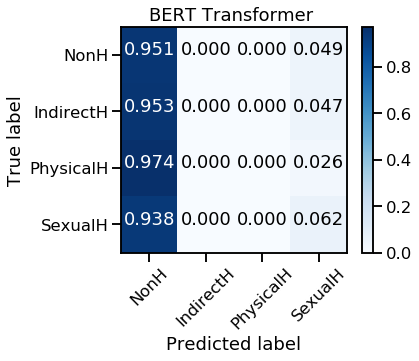

Test_ acc: 0.7268016957136129
Test_ f1 none: [0.842 0.    0.    0.094]
Test_ f1 macro: 0.2338852881527017


In [16]:
path_a = '../../../Datasets/CSV_Harassment/Aumento_ofi/' 
best_0, all_accs_0, all_fno_0, all_ma_0, all_cm_0 = train_transformer(0.0, 60, path_a, path_m, "Blues")

In [17]:
print ("best_0", best_0)
print ("all_accs_0", all_accs_0)
print ("all_fno_0", all_fno_0)
print ("all_ma_0", all_ma_0)

best_0 {'F_ma': 0.2391156682623884, 'Run': 8}
all_accs_0 [0.7041921808761187, 0.7206782854451248, 0.7183231276495525, 0.7268016957136129, 0.7216203485633538, 0.7291568535091851, 0.7183231276495525, 0.7079604333490344, 0.7352802637776731, 0.7381064531323599, 0.7164390014130947, 0.7225624116815826, 0.7131417804992934, 0.7192651907677814, 0.7268016957136129, 0.7329251059821008, 0.7225624116815826, 0.7183231276495525, 0.7282147903909562, 0.7268016957136129]
all_fno_0 [array([0.828, 0.   , 0.   , 0.101]), array([0.838, 0.   , 0.   , 0.054]), array([0.837, 0.   , 0.   , 0.085]), array([0.843, 0.   , 0.   , 0.06 ]), array([0.839, 0.   , 0.   , 0.098]), array([0.844, 0.   , 0.   , 0.066]), array([0.836, 0.   , 0.   , 0.101]), array([0.831, 0.   , 0.   , 0.126]), array([0.848, 0.   , 0.   , 0.04 ]), array([0.849, 0.   , 0.   , 0.069]), array([0.836, 0.   , 0.   , 0.04 ]), array([0.839, 0.   , 0.   , 0.042]), array([0.833, 0.   , 0.   , 0.08 ]), array([0.838, 0.   , 0.   , 0.086]), array([0.843,

Acc: 0.722 -- deviation: 0.008
F-score: 0.228 -- deviation: 0.006
(0.0) SDQC: 0.8395374147393321 0.0 0.0 0.07290892819038498


Confusion counts
[[30337.     0.     0.  1683.]
 [ 2010.     0.     0.   110.]
 [ 1435.     0.     0.    85.]
 [ 6465.     0.     0.   335.]]


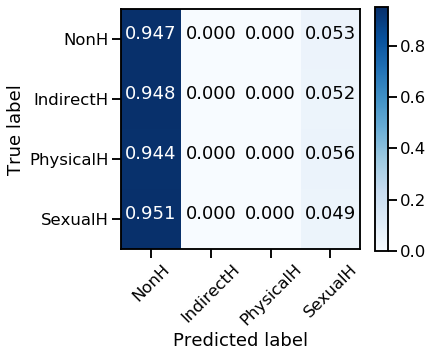

In [18]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_0)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_0)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_0)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_0)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_0)[:,0])
den=np.mean(np.asarray(all_fno_0)[:,1])
que=np.mean(np.asarray(all_fno_0)[:,2])
com=np.mean(np.asarray(all_fno_0)[:,3])

print ("(0.0) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_0:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='Blues')

## 0.0 CW

In [19]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights

array([ 0.435, 28.973, 20.967,  0.617])

Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.206 	F-macro_val: 0.141
Epoch 10 	acc_val: 0.065 	F-macro_val: 0.061
Epoch 20 	acc_val: 0.056 	F-macro_val: 0.055
Epoch 30 	acc_val: 0.095 	F-macro_val: 0.088
Epoch 40 	acc_val: 0.133 	F-macro_val: 0.119
Epoch 50 	acc_val: 0.146 	F-macro_val: 0.127
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


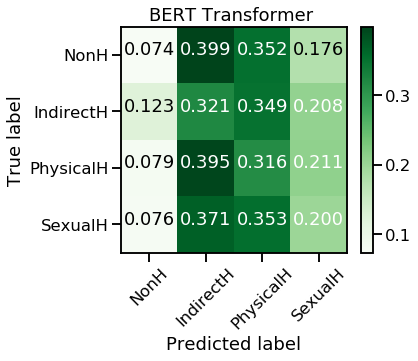

Test_ acc: 0.1149317004239284
Test_ f1 none: [0.134 0.073 0.059 0.187]
Test_ f1 macro: 0.11298543985947458


Nuevo best encontrado:

Acc: 0.115 	F1-ma: 0.113
	F1-none:  [0.134 0.073 0.059 0.187]
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.158 	F-macro_val: 0.109
Epoch 10 	acc_val: 0.045 	F-macro_val: 0.038
Epoch 20 	acc_val: 0.055 	F-macro_val: 0.051
Epoch 30 	acc_val: 0.098 	F-macro_val: 0.086
Epoch 40 	acc_val: 0.118 	F-macro_val: 0.108
Epoch 50 	acc_val: 0.151 	F-macro_val: 0.136
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


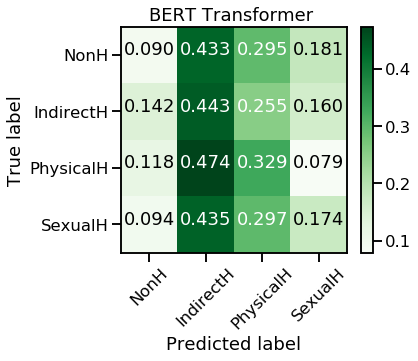

Test_ acc: 0.12953367875647667
Test_ f1 none: [0.16  0.091 0.071 0.166]
Test_ f1 macro: 0.12201004665422029


Nuevo best encontrado:

Acc: 0.130 	F1-ma: 0.122
	F1-none:  [0.16  0.091 0.071 0.166]
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.171 	F-macro_val: 0.127
Epoch 10 	acc_val: 0.052 	F-macro_val: 0.047
Epoch 20 	acc_val: 0.050 	F-macro_val: 0.048
Epoch 30 	acc_val: 0.110 	F-macro_val: 0.106
Epoch 40 	acc_val: 0.138 	F-macro_val: 0.129
Epoch 50 	acc_val: 0.181 	F-macro_val: 0.155
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


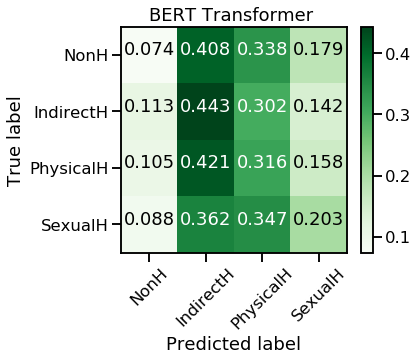

Test_ acc: 0.12199717381064532
Test_ f1 none: [0.134 0.098 0.061 0.191]
Test_ f1 macro: 0.12093260599889209
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.239 	F-macro_val: 0.142
Epoch 10 	acc_val: 0.051 	F-macro_val: 0.043
Epoch 20 	acc_val: 0.052 	F-macro_val: 0.049
Epoch 30 	acc_val: 0.096 	F-macro_val: 0.090
Epoch 40 	acc_val: 0.115 	F-macro_val: 0.108
Epoch 50 	acc_val: 0.159 	F-macro_val: 0.140
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


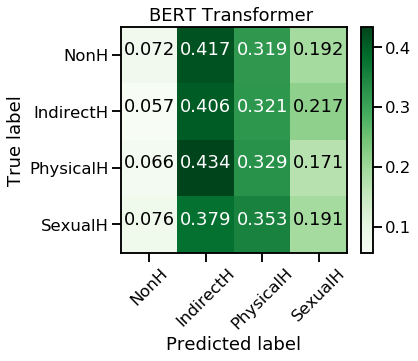

Test_ acc: 0.1172868582195007
Test_ f1 none: [0.132 0.088 0.065 0.174]
Test_ f1 macro: 0.1148186506022261
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.166 	F-macro_val: 0.121
Epoch 10 	acc_val: 0.060 	F-macro_val: 0.057
Epoch 20 	acc_val: 0.058 	F-macro_val: 0.055
Epoch 30 	acc_val: 0.087 	F-macro_val: 0.083
Epoch 40 	acc_val: 0.148 	F-macro_val: 0.123
Epoch 50 	acc_val: 0.162 	F-macro_val: 0.133
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


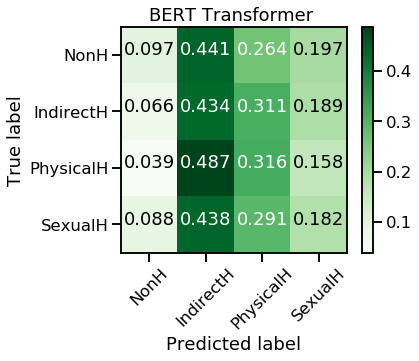

Test_ acc: 0.13565708902496468
Test_ f1 none: [0.174 0.088 0.073 0.165]
Test_ f1 macro: 0.12509027148823054


Nuevo best encontrado:

Acc: 0.136 	F1-ma: 0.125
	F1-none:  [0.174 0.088 0.073 0.165]
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.333 	F-macro_val: 0.182
Epoch 10 	acc_val: 0.061 	F-macro_val: 0.059
Epoch 20 	acc_val: 0.050 	F-macro_val: 0.047
Epoch 30 	acc_val: 0.093 	F-macro_val: 0.091
Epoch 40 	acc_val: 0.128 	F-macro_val: 0.116
Epoch 50 	acc_val: 0.125 	F-macro_val: 0.110
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


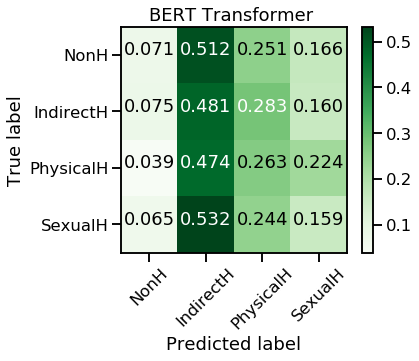

Test_ acc: 0.1125765426283561
Test_ f1 none: [0.13  0.085 0.065 0.156]
Test_ f1 macro: 0.10929313064410381
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.323 	F-macro_val: 0.186
Epoch 10 	acc_val: 0.062 	F-macro_val: 0.059
Epoch 20 	acc_val: 0.053 	F-macro_val: 0.051
Epoch 30 	acc_val: 0.083 	F-macro_val: 0.081
Epoch 40 	acc_val: 0.128 	F-macro_val: 0.115
Epoch 50 	acc_val: 0.157 	F-macro_val: 0.139
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


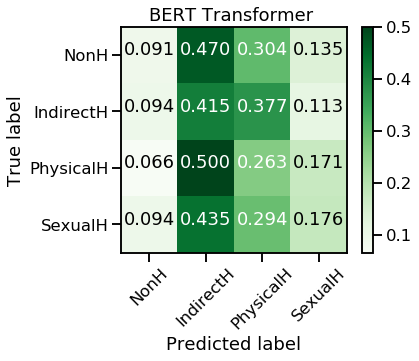

Test_ acc: 0.12717852096090437
Test_ f1 none: [0.163 0.081 0.055 0.187]
Test_ f1 macro: 0.12154550065447449
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.202 	F-macro_val: 0.146
Epoch 10 	acc_val: 0.053 	F-macro_val: 0.050
Epoch 20 	acc_val: 0.056 	F-macro_val: 0.055
Epoch 30 	acc_val: 0.094 	F-macro_val: 0.089
Epoch 40 	acc_val: 0.114 	F-macro_val: 0.108
Epoch 50 	acc_val: 0.133 	F-macro_val: 0.123
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


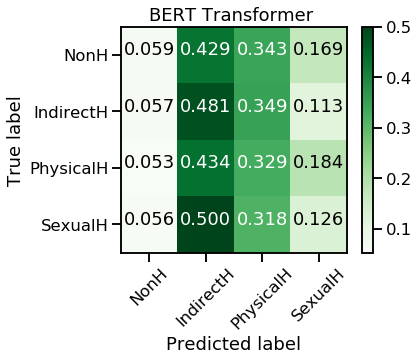

Test_ acc: 0.10080075365049458
Test_ f1 none: [0.11  0.097 0.063 0.127]
Test_ f1 macro: 0.0992790152604916
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.350 	F-macro_val: 0.192
Epoch 10 	acc_val: 0.072 	F-macro_val: 0.066
Epoch 20 	acc_val: 0.056 	F-macro_val: 0.053
Epoch 30 	acc_val: 0.092 	F-macro_val: 0.092
Epoch 40 	acc_val: 0.120 	F-macro_val: 0.114
Epoch 50 	acc_val: 0.151 	F-macro_val: 0.135
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


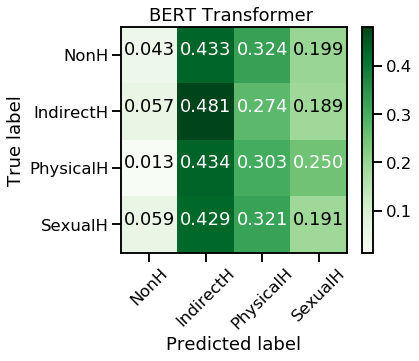

Test_ acc: 0.09797456429580782
Test_ f1 none: [0.081 0.099 0.061 0.17 ]
Test_ f1 macro: 0.1028939355315262
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.246 	F-macro_val: 0.161
Epoch 10 	acc_val: 0.069 	F-macro_val: 0.065
Epoch 20 	acc_val: 0.066 	F-macro_val: 0.066
Epoch 30 	acc_val: 0.095 	F-macro_val: 0.098
Epoch 40 	acc_val: 0.144 	F-macro_val: 0.132
Epoch 50 	acc_val: 0.147 	F-macro_val: 0.137
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


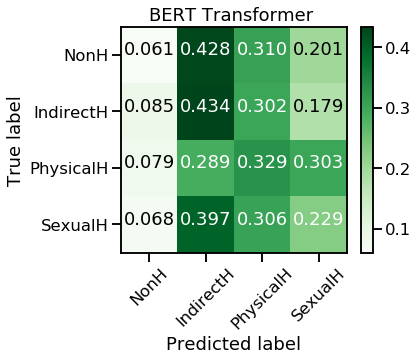

Test_ acc: 0.11587376354215732
Test_ f1 none: [0.112 0.092 0.068 0.199]
Test_ f1 macro: 0.11797869467275726
Entrenando Run # 11
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.283 	F-macro_val: 0.174
Epoch 10 	acc_val: 0.080 	F-macro_val: 0.074
Epoch 20 	acc_val: 0.061 	F-macro_val: 0.054
Epoch 30 	acc_val: 0.101 	F-macro_val: 0.093
Epoch 40 	acc_val: 0.146 	F-macro_val: 0.132
Epoch 50 	acc_val: 0.163 	F-macro_val: 0.143
Testing run # 11
SE TUVIERON QUE REPETIR 21 EJEMPLOS


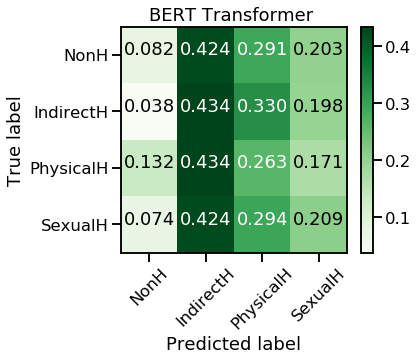

Test_ acc: 0.12623645784267545
Test_ f1 none: [0.148 0.091 0.057 0.184]
Test_ f1 macro: 0.1202533130929675
Entrenando Run # 12
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.271 	F-macro_val: 0.171
Epoch 10 	acc_val: 0.062 	F-macro_val: 0.058
Epoch 20 	acc_val: 0.050 	F-macro_val: 0.046
Epoch 30 	acc_val: 0.090 	F-macro_val: 0.087
Epoch 40 	acc_val: 0.114 	F-macro_val: 0.103
Epoch 50 	acc_val: 0.139 	F-macro_val: 0.124
Testing run # 12
SE TUVIERON QUE REPETIR 21 EJEMPLOS


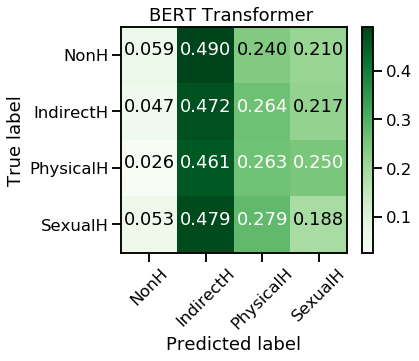

Test_ acc: 0.10786622703721149
Test_ f1 none: [0.11  0.088 0.066 0.163]
Test_ f1 macro: 0.10700151315031767
Entrenando Run # 13
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.182 	F-macro_val: 0.120
Epoch 10 	acc_val: 0.062 	F-macro_val: 0.064
Epoch 20 	acc_val: 0.060 	F-macro_val: 0.056
Epoch 30 	acc_val: 0.096 	F-macro_val: 0.090
Epoch 40 	acc_val: 0.107 	F-macro_val: 0.100
Epoch 50 	acc_val: 0.130 	F-macro_val: 0.121
Testing run # 13
SE TUVIERON QUE REPETIR 21 EJEMPLOS


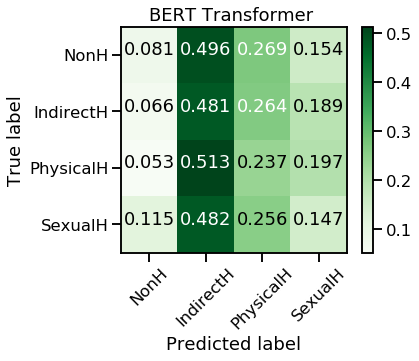

Test_ acc: 0.11681582666038624
Test_ f1 none: [0.145 0.088 0.056 0.149]
Test_ f1 macro: 0.10959788973473056
Entrenando Run # 14
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.230 	F-macro_val: 0.152
Epoch 10 	acc_val: 0.059 	F-macro_val: 0.056
Epoch 20 	acc_val: 0.055 	F-macro_val: 0.052
Epoch 30 	acc_val: 0.094 	F-macro_val: 0.089
Epoch 40 	acc_val: 0.124 	F-macro_val: 0.116
Epoch 50 	acc_val: 0.158 	F-macro_val: 0.142
Testing run # 14
SE TUVIERON QUE REPETIR 21 EJEMPLOS


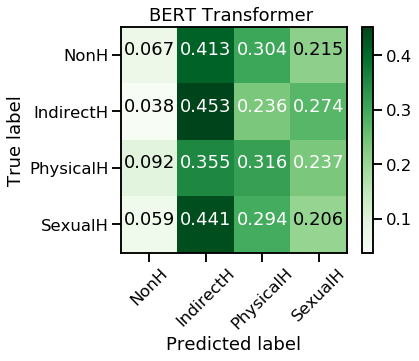

Test_ acc: 0.1172868582195007
Test_ f1 none: [0.123 0.097 0.067 0.175]
Test_ f1 macro: 0.1154288219904629
Entrenando Run # 15
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.348 	F-macro_val: 0.185
Epoch 10 	acc_val: 0.065 	F-macro_val: 0.056
Epoch 20 	acc_val: 0.058 	F-macro_val: 0.056
Epoch 30 	acc_val: 0.094 	F-macro_val: 0.094
Epoch 40 	acc_val: 0.156 	F-macro_val: 0.140
Epoch 50 	acc_val: 0.179 	F-macro_val: 0.155
Testing run # 15
SE TUVIERON QUE REPETIR 21 EJEMPLOS


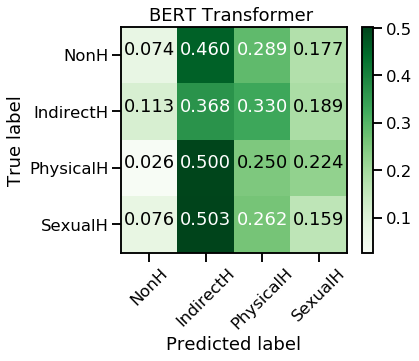

Test_ acc: 0.10880829015544041
Test_ f1 none: [0.135 0.072 0.056 0.151]
Test_ f1 macro: 0.10340903762237574
Entrenando Run # 16
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.297 	F-macro_val: 0.173
Epoch 10 	acc_val: 0.064 	F-macro_val: 0.057
Epoch 20 	acc_val: 0.062 	F-macro_val: 0.060
Epoch 30 	acc_val: 0.096 	F-macro_val: 0.088
Epoch 40 	acc_val: 0.142 	F-macro_val: 0.127
Epoch 50 	acc_val: 0.176 	F-macro_val: 0.154
Testing run # 16
SE TUVIERON QUE REPETIR 21 EJEMPLOS


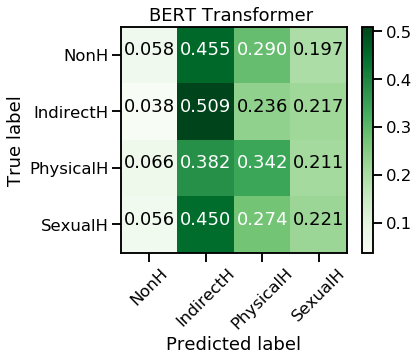

Test_ acc: 0.11681582666038624
Test_ f1 none: [0.108 0.101 0.076 0.195]
Test_ f1 macro: 0.11998404569620397
Entrenando Run # 17
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.251 	F-macro_val: 0.156
Epoch 10 	acc_val: 0.060 	F-macro_val: 0.057
Epoch 20 	acc_val: 0.054 	F-macro_val: 0.051
Epoch 30 	acc_val: 0.083 	F-macro_val: 0.079
Epoch 40 	acc_val: 0.140 	F-macro_val: 0.129
Epoch 50 	acc_val: 0.152 	F-macro_val: 0.136
Testing run # 17
SE TUVIERON QUE REPETIR 21 EJEMPLOS


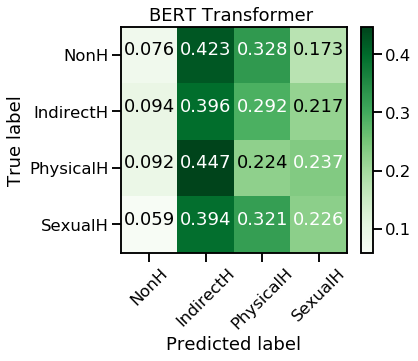

Test_ acc: 0.1210551106924164
Test_ f1 none: [0.138 0.085 0.045 0.21 ]
Test_ f1 macro: 0.11911597561456538
Entrenando Run # 18
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.265 	F-macro_val: 0.159
Epoch 10 	acc_val: 0.064 	F-macro_val: 0.056
Epoch 20 	acc_val: 0.068 	F-macro_val: 0.069
Epoch 30 	acc_val: 0.098 	F-macro_val: 0.095
Epoch 40 	acc_val: 0.130 	F-macro_val: 0.120
Epoch 50 	acc_val: 0.169 	F-macro_val: 0.149
Testing run # 18
SE TUVIERON QUE REPETIR 21 EJEMPLOS


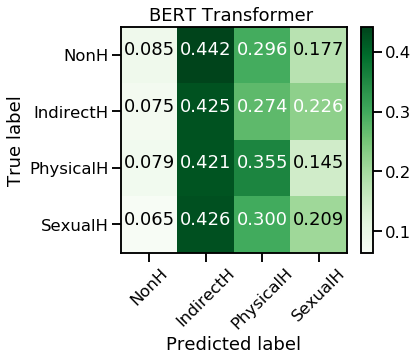

Test_ acc: 0.13141780499293454
Test_ f1 none: [0.153 0.087 0.076 0.195]
Test_ f1 macro: 0.12779013791732227


Nuevo best encontrado:

Acc: 0.131 	F1-ma: 0.128
	F1-none:  [0.153 0.087 0.076 0.195]
Entrenando Run # 19
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.434 	F-macro_val: 0.214
Epoch 10 	acc_val: 0.084 	F-macro_val: 0.071
Epoch 20 	acc_val: 0.060 	F-macro_val: 0.061
Epoch 30 	acc_val: 0.091 	F-macro_val: 0.098
Epoch 40 	acc_val: 0.134 	F-macro_val: 0.128
Epoch 50 	acc_val: 0.179 	F-macro_val: 0.157
Testing run # 19
SE TUVIERON QUE REPETIR 21 EJEMPLOS


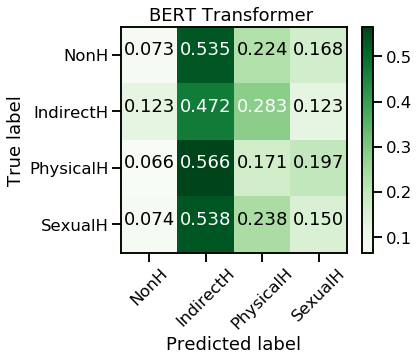

Test_ acc: 0.10880829015544041
Test_ f1 none: [0.133 0.081 0.047 0.148]
Test_ f1 macro: 0.10210548303050035
Entrenando Run # 20
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.243 	F-macro_val: 0.159
Epoch 10 	acc_val: 0.074 	F-macro_val: 0.067
Epoch 20 	acc_val: 0.068 	F-macro_val: 0.065
Epoch 30 	acc_val: 0.105 	F-macro_val: 0.100
Epoch 40 	acc_val: 0.161 	F-macro_val: 0.143
Epoch 50 	acc_val: 0.182 	F-macro_val: 0.160
Testing run # 20
SE TUVIERON QUE REPETIR 21 EJEMPLOS


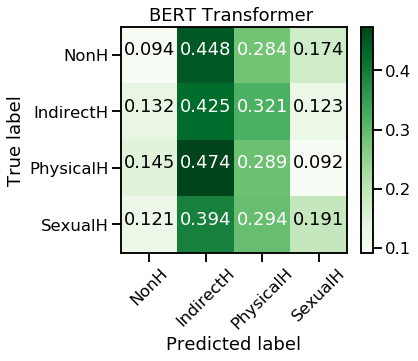

Test_ acc: 0.13283089967027792
Test_ f1 none: [0.165 0.087 0.064 0.185]
Test_ f1 macro: 0.1251295480773736


In [20]:
best_0cw, all_accs_0cw, all_fno_0cw, all_ma_0cw, all_cm_0cw =train_transformer(0.0, 60, path_a, path_m, "Greens", class_weights=class_weights)

In [21]:
print ("best_0cw", best_0cw)
print ("all_accs_0cw", all_accs_0cw)
print ("all_fno_0cw", all_fno_0cw)
print ("all_ma_0cw", all_ma_0cw)

best_0cw {'F_ma': 0.12779013791732227, 'Run': 18}
all_accs_0cw [0.1149317004239284, 0.12953367875647667, 0.12199717381064532, 0.1172868582195007, 0.13565708902496468, 0.1125765426283561, 0.12717852096090437, 0.10080075365049458, 0.09797456429580782, 0.11587376354215732, 0.12623645784267545, 0.10786622703721149, 0.11681582666038624, 0.1172868582195007, 0.10880829015544041, 0.11681582666038624, 0.1210551106924164, 0.13141780499293454, 0.10880829015544041, 0.13283089967027792]
all_fno_0cw [array([0.134, 0.073, 0.059, 0.187]), array([0.16 , 0.091, 0.071, 0.166]), array([0.134, 0.098, 0.061, 0.191]), array([0.132, 0.088, 0.065, 0.174]), array([0.174, 0.088, 0.073, 0.165]), array([0.13 , 0.085, 0.065, 0.156]), array([0.163, 0.081, 0.055, 0.187]), array([0.11 , 0.097, 0.063, 0.127]), array([0.081, 0.099, 0.061, 0.17 ]), array([0.112, 0.092, 0.068, 0.199]), array([0.148, 0.091, 0.057, 0.184]), array([0.11 , 0.088, 0.066, 0.163]), array([0.145, 0.088, 0.056, 0.149]), array([0.123, 0.097, 0.067,

Acc: 0.118 -- deviation: 0.010
F-score: 0.115 -- deviation: 0.008
(0.0cw) NIPS: 0.13445148683891983 0.08841860818774006 0.06263594998554364 0.1738225664464399


Confusion counts
[[ 2372. 14342.  9470.  5836.]
 [  173.   930.   631.   386.]
 [  109.   676.   441.   294.]
 [  515.  2996.  2018.  1271.]]


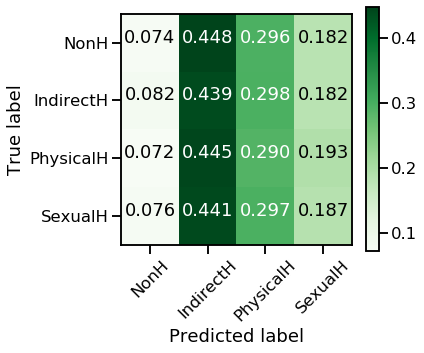

In [22]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_0cw)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_0cw)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_0cw)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_0cw)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_0cw)[:,0])
den=np.mean(np.asarray(all_fno_0cw)[:,1])
que=np.mean(np.asarray(all_fno_0cw)[:,2])
com=np.mean(np.asarray(all_fno_0cw)[:,3])

print ("(0.0cw) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_0cw:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='Greens')

## Con aumento de datos

### 0.15

In [23]:
class_weights= np.asarray([1.0, 1.0, 1.0, 1.0]) 

print ("Pesos de clases:", class_weights)

Pesos de clases: [1. 1. 1. 1.]


Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.179 	F-macro_val: 0.130
Epoch 10 	acc_val: 0.342 	F-macro_val: 0.209
Epoch 20 	acc_val: 0.330 	F-macro_val: 0.204
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


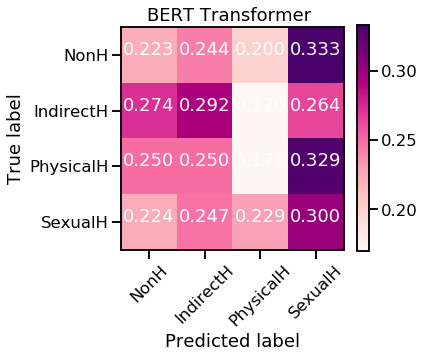

Test_ acc: 0.2369288742345737
Test_ f1 none: [0.343 0.098 0.051 0.198]
Test_ f1 macro: 0.17279478966418327


Nuevo best encontrado:

Acc: 0.237 	F1-ma: 0.173
	F1-none:  [0.343 0.098 0.051 0.198]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.239 	F-macro_val: 0.150
Epoch 10 	acc_val: 0.343 	F-macro_val: 0.202
Epoch 20 	acc_val: 0.354 	F-macro_val: 0.204
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


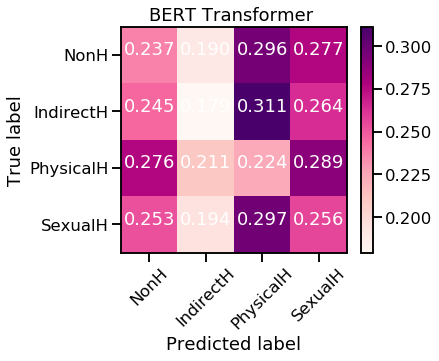

Test_ acc: 0.2369288742345737
Test_ f1 none: [0.36  0.074 0.049 0.189]
Test_ f1 macro: 0.16787615209558804
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.162 	F-macro_val: 0.115
Epoch 10 	acc_val: 0.347 	F-macro_val: 0.206
Epoch 20 	acc_val: 0.355 	F-macro_val: 0.211
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


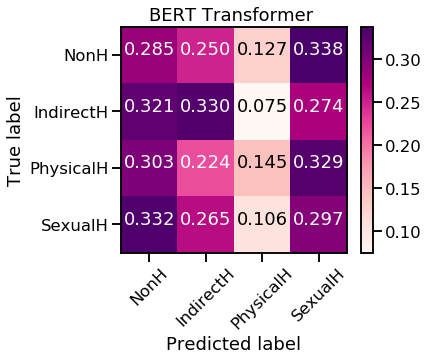

Test_ acc: 0.28450306170513423
Test_ f1 none: [0.41  0.108 0.066 0.195]
Test_ f1 macro: 0.19477676074737788


Nuevo best encontrado:

Acc: 0.285 	F1-ma: 0.195
	F1-none:  [0.41  0.108 0.066 0.195]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.316 	F-macro_val: 0.173
Epoch 10 	acc_val: 0.286 	F-macro_val: 0.175
Epoch 20 	acc_val: 0.322 	F-macro_val: 0.198
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


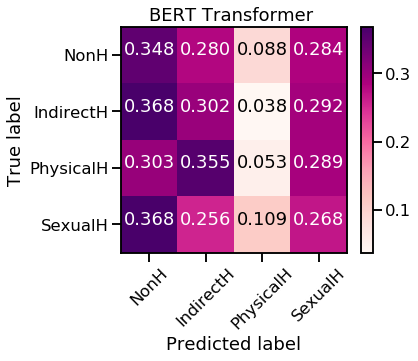

Test_ acc: 0.32218558643429107
Test_ f1 none: [0.475 0.091 0.031 0.194]
Test_ f1 macro: 0.19772891307544438


Nuevo best encontrado:

Acc: 0.322 	F1-ma: 0.198
	F1-none:  [0.475 0.091 0.031 0.194]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.208 	F-macro_val: 0.137
Epoch 10 	acc_val: 0.336 	F-macro_val: 0.201
Epoch 20 	acc_val: 0.374 	F-macro_val: 0.221
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


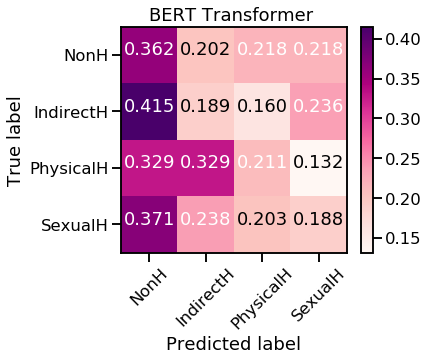

Test_ acc: 0.3198304286387188
Test_ f1 none: [0.488 0.072 0.061 0.162]
Test_ f1 macro: 0.19566975106338313
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.278 	F-macro_val: 0.172
Epoch 10 	acc_val: 0.301 	F-macro_val: 0.184
Epoch 20 	acc_val: 0.390 	F-macro_val: 0.219
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


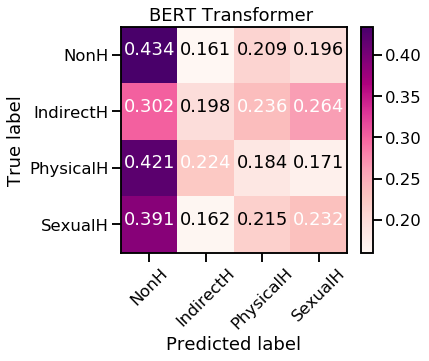

Test_ acc: 0.3810645313235987
Test_ f1 none: [0.558 0.092 0.054 0.204]
Test_ f1 macro: 0.22683452156434492


Nuevo best encontrado:

Acc: 0.381 	F1-ma: 0.227
	F1-none:  [0.558 0.092 0.054 0.204]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.257 	F-macro_val: 0.163
Epoch 10 	acc_val: 0.304 	F-macro_val: 0.188
Epoch 20 	acc_val: 0.319 	F-macro_val: 0.196
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


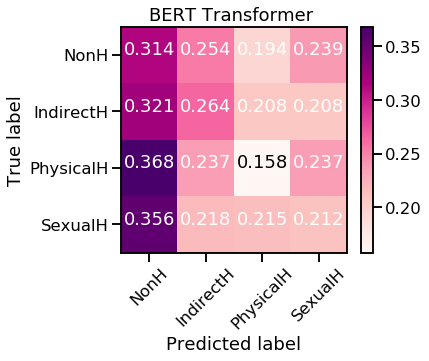

Test_ acc: 0.28921337729627883
Test_ f1 none: [0.439 0.088 0.049 0.173]
Test_ f1 macro: 0.18725153180803397
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.233 	F-macro_val: 0.152
Epoch 10 	acc_val: 0.332 	F-macro_val: 0.199
Epoch 20 	acc_val: 0.383 	F-macro_val: 0.218
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


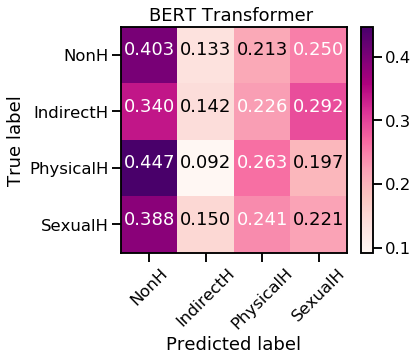

Test_ acc: 0.3560998586905323
Test_ f1 none: [0.528 0.077 0.074 0.174]
Test_ f1 macro: 0.21294290717976042
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.238 	F-macro_val: 0.163
Epoch 10 	acc_val: 0.310 	F-macro_val: 0.188
Epoch 20 	acc_val: 0.360 	F-macro_val: 0.211
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


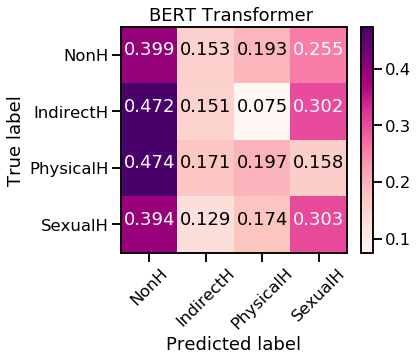

Test_ acc: 0.36363636363636365
Test_ f1 none: [0.519 0.075 0.064 0.23 ]
Test_ f1 macro: 0.22213309179005475
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.312 	F-macro_val: 0.180
Epoch 10 	acc_val: 0.305 	F-macro_val: 0.185
Epoch 20 	acc_val: 0.352 	F-macro_val: 0.210
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


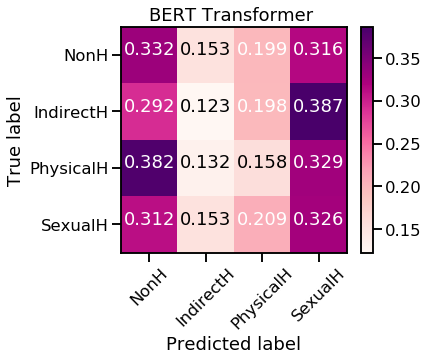

Test_ acc: 0.3141780499293453
Test_ f1 none: [0.462 0.061 0.048 0.217]
Test_ f1 macro: 0.19706971151389893
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.176 	F-macro_val: 0.126
Epoch 10 	acc_val: 0.235 	F-macro_val: 0.158
Epoch 20 	acc_val: 0.306 	F-macro_val: 0.192
Testing run # 11
SE TUVIERON QUE REPETIR 21 EJEMPLOS


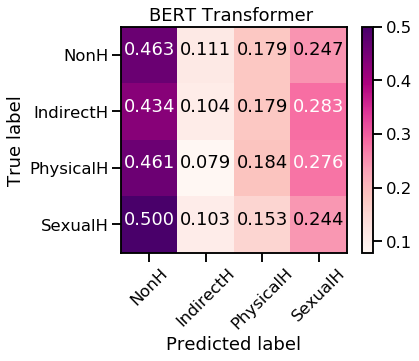

Test_ acc: 0.3999057936881771
Test_ f1 none: [0.572 0.065 0.062 0.191]
Test_ f1 macro: 0.22263477859476033
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 12
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.152
Epoch 10 	acc_val: 0.316 	F-macro_val: 0.194
Epoch 20 	acc_val: 0.332 	F-macro_val: 0.205
Testing run # 12
SE TUVIERON QUE REPETIR 21 EJEMPLOS


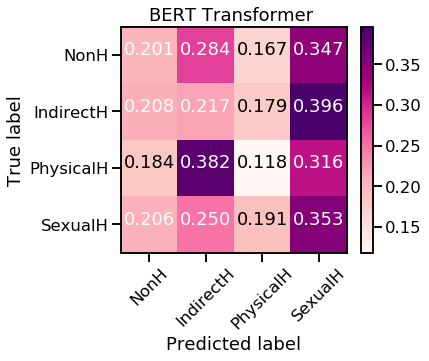

Test_ acc: 0.22326895902025437
Test_ f1 none: [0.317 0.066 0.041 0.222]
Test_ f1 macro: 0.16157542581969817
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 13
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.157 	F-macro_val: 0.115
Epoch 10 	acc_val: 0.326 	F-macro_val: 0.196
Epoch 20 	acc_val: 0.335 	F-macro_val: 0.209
Testing run # 13
SE TUVIERON QUE REPETIR 21 EJEMPLOS


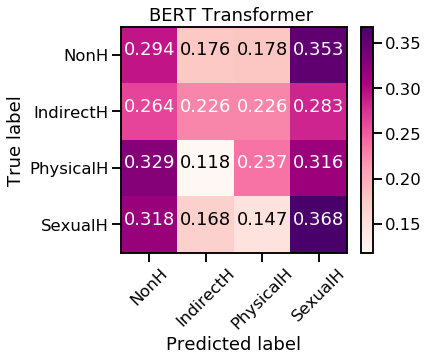

Test_ acc: 0.30004710315591143
Test_ f1 none: [0.421 0.101 0.079 0.231]
Test_ f1 macro: 0.20796834729279687
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 14
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.319 	F-macro_val: 0.191
Epoch 10 	acc_val: 0.353 	F-macro_val: 0.215
Epoch 20 	acc_val: 0.322 	F-macro_val: 0.199
Testing run # 14
SE TUVIERON QUE REPETIR 21 EJEMPLOS


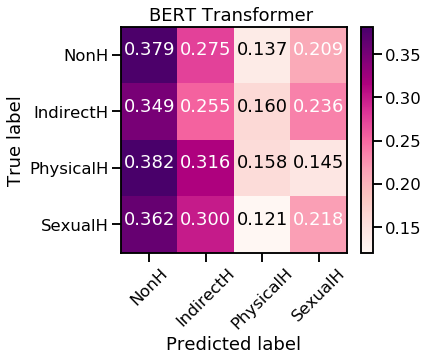

Test_ acc: 0.3391427225624117
Test_ f1 none: [0.506 0.077 0.066 0.189]
Test_ f1 macro: 0.20951722898344516
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 15
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.349 	F-macro_val: 0.192
Epoch 10 	acc_val: 0.315 	F-macro_val: 0.188
Epoch 20 	acc_val: 0.320 	F-macro_val: 0.196
Testing run # 15
SE TUVIERON QUE REPETIR 21 EJEMPLOS


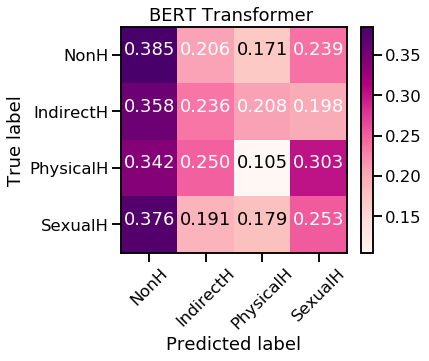

Test_ acc: 0.3462081959491286
Test_ f1 none: [0.511 0.092 0.036 0.202]
Test_ f1 macro: 0.21035005375403681
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 16
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.241 	F-macro_val: 0.163
Epoch 10 	acc_val: 0.325 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.402 	F-macro_val: 0.223
Testing run # 16
SE TUVIERON QUE REPETIR 21 EJEMPLOS


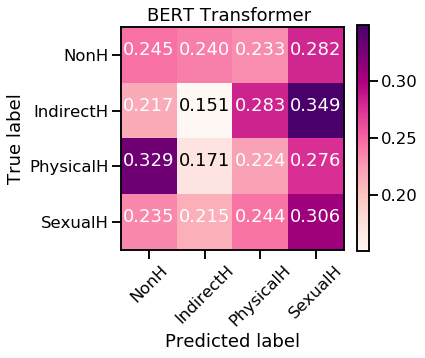

Test_ acc: 0.24964672633066415
Test_ f1 none: [0.37  0.054 0.059 0.218]
Test_ f1 macro: 0.17535984966932575
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 17
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.227 	F-macro_val: 0.149
Epoch 10 	acc_val: 0.318 	F-macro_val: 0.186
Epoch 20 	acc_val: 0.299 	F-macro_val: 0.187
Testing run # 17
SE TUVIERON QUE REPETIR 21 EJEMPLOS


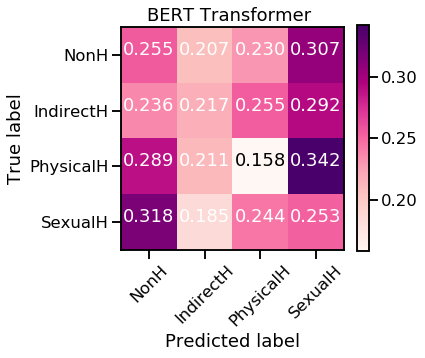

Test_ acc: 0.24964672633066415
Test_ f1 none: [0.378 0.085 0.042 0.176]
Test_ f1 macro: 0.17045684193943114
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 18
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.326 	F-macro_val: 0.178
Epoch 10 	acc_val: 0.297 	F-macro_val: 0.188
Epoch 20 	acc_val: 0.317 	F-macro_val: 0.196
Testing run # 18
SE TUVIERON QUE REPETIR 21 EJEMPLOS


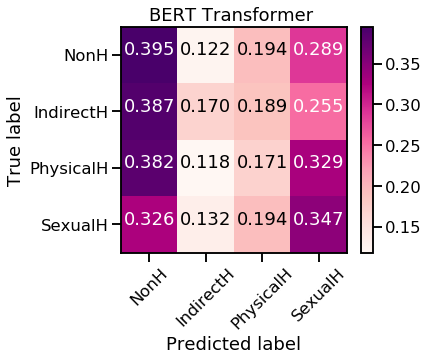

Test_ acc: 0.36834667922750824
Test_ f1 none: [0.524 0.096 0.054 0.243]
Test_ f1 macro: 0.22922172207714905


Nuevo best encontrado:

Acc: 0.368 	F1-ma: 0.229
	F1-none:  [0.524 0.096 0.054 0.243]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 19
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.234 	F-macro_val: 0.152
Epoch 10 	acc_val: 0.279 	F-macro_val: 0.181
Epoch 20 	acc_val: 0.326 	F-macro_val: 0.195
Testing run # 19
SE TUVIERON QUE REPETIR 21 EJEMPLOS


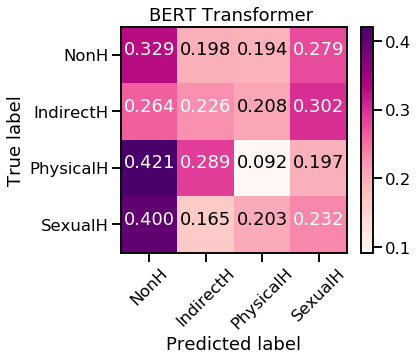

Test_ acc: 0.299576071596797
Test_ f1 none: [0.453 0.091 0.029 0.173]
Test_ f1 macro: 0.1865532720462419
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 20
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.216 	F-macro_val: 0.142
Epoch 10 	acc_val: 0.320 	F-macro_val: 0.200
Epoch 20 	acc_val: 0.371 	F-macro_val: 0.224
Testing run # 20
SE TUVIERON QUE REPETIR 21 EJEMPLOS


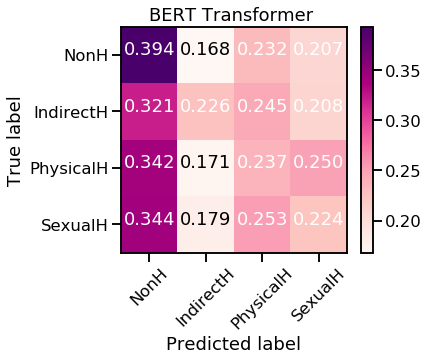

Test_ acc: 0.35233160621761656
Test_ f1 none: [0.523 0.101 0.062 0.193]
Test_ f1 macro: 0.2200052028778265


In [24]:
best_15, all_accs_15, all_fno_15, all_ma_15, all_cm_15 = train_transformer(0.15, 26, path_a, path_m, "RdPu", augmented=True)


In [25]:
print ("best_15", best_15)
print ("all_accs_15", all_accs_15)
print ("all_fno_15", all_fno_15)
print ("all_ma_15", all_ma_15)

best_15 {'F_ma': 0.22922172207714905, 'Run': 18}
all_accs_15 [0.2369288742345737, 0.2369288742345737, 0.28450306170513423, 0.32218558643429107, 0.3198304286387188, 0.3810645313235987, 0.28921337729627883, 0.3560998586905323, 0.36363636363636365, 0.3141780499293453, 0.3999057936881771, 0.22326895902025437, 0.30004710315591143, 0.3391427225624117, 0.3462081959491286, 0.24964672633066415, 0.24964672633066415, 0.36834667922750824, 0.299576071596797, 0.35233160621761656]
all_fno_15 [array([0.343, 0.098, 0.051, 0.198]), array([0.36 , 0.074, 0.049, 0.189]), array([0.41 , 0.108, 0.066, 0.195]), array([0.475, 0.091, 0.031, 0.194]), array([0.488, 0.072, 0.061, 0.162]), array([0.558, 0.092, 0.054, 0.204]), array([0.439, 0.088, 0.049, 0.173]), array([0.528, 0.077, 0.074, 0.174]), array([0.519, 0.075, 0.064, 0.23 ]), array([0.462, 0.061, 0.048, 0.217]), array([0.572, 0.065, 0.062, 0.191]), array([0.317, 0.066, 0.041, 0.222]), array([0.421, 0.101, 0.079, 0.231]), array([0.506, 0.077, 0.066, 0.189]),

Acc: 0.312 -- deviation: 0.051
F-score: 0.198 -- deviation: 0.021
(0.15) NIPS: 0.45786123430423664 0.08335292371129902 0.053815854743356664 0.19871415795246383


Confusion counts
[[10689.  6416.  6168.  8747.]
 [  677.   445.   406.   592.]
 [  533.   329.   262.   396.]
 [ 2303.  1326.  1335.  1836.]]


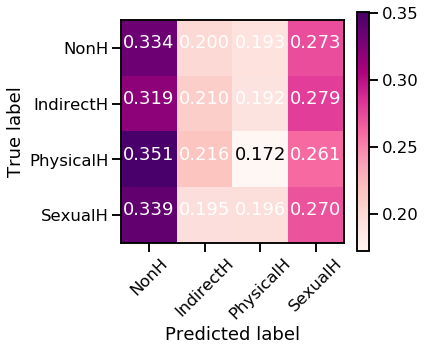

In [26]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_15)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_15)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_15)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_15)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_15)[:,0])
den=np.mean(np.asarray(all_fno_15)[:,1])
que=np.mean(np.asarray(all_fno_15)[:,2])
com=np.mean(np.asarray(all_fno_15)[:,3])

print ("(0.15) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_15:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='RdPu')

## 0.5 mask

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.184 	F-macro_val: 0.125
Epoch 10 	acc_val: 0.283 	F-macro_val: 0.178
Epoch 20 	acc_val: 0.299 	F-macro_val: 0.193
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


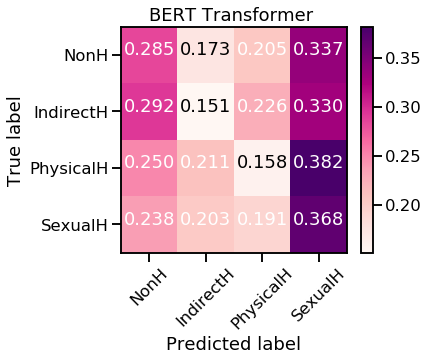

Test_ acc: 0.28685821950070656
Test_ f1 none: [0.417 0.066 0.047 0.234]
Test_ f1 macro: 0.1911119855799212


Nuevo best encontrado:

Acc: 0.287 	F1-ma: 0.191
	F1-none:  [0.417 0.066 0.047 0.234]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.286 	F-macro_val: 0.175
Epoch 10 	acc_val: 0.307 	F-macro_val: 0.185
Epoch 20 	acc_val: 0.329 	F-macro_val: 0.199
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


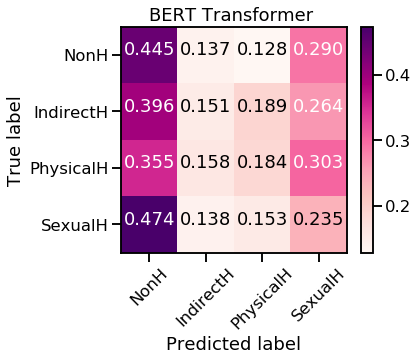

Test_ acc: 0.3871879415920867
Test_ f1 none: [0.56  0.08  0.076 0.171]
Test_ f1 macro: 0.22180074749063083


Nuevo best encontrado:

Acc: 0.387 	F1-ma: 0.222
	F1-none:  [0.56  0.08  0.076 0.171]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.248 	F-macro_val: 0.161
Epoch 10 	acc_val: 0.316 	F-macro_val: 0.199
Epoch 20 	acc_val: 0.371 	F-macro_val: 0.219
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


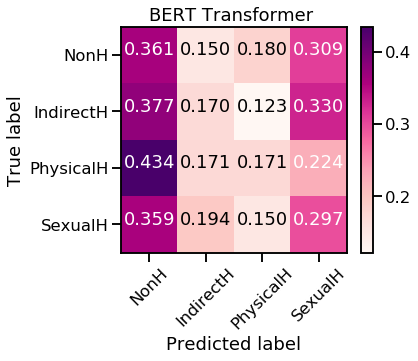

Test_ acc: 0.3344324069712671
Test_ f1 none: [0.487 0.081 0.059 0.204]
Test_ f1 macro: 0.2079040840021567
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.300 	F-macro_val: 0.174
Epoch 10 	acc_val: 0.323 	F-macro_val: 0.196
Epoch 20 	acc_val: 0.354 	F-macro_val: 0.215
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


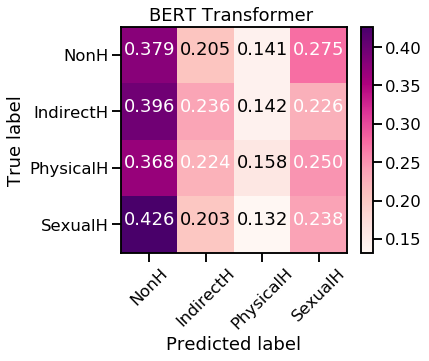

Test_ acc: 0.3410268487988695
Test_ f1 none: [0.5   0.092 0.064 0.179]
Test_ f1 macro: 0.20883416547290404
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.309 	F-macro_val: 0.183
Epoch 10 	acc_val: 0.333 	F-macro_val: 0.205
Epoch 20 	acc_val: 0.389 	F-macro_val: 0.231
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


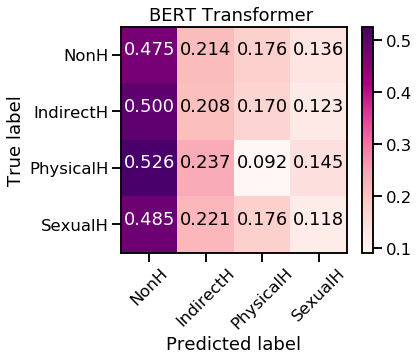

Test_ acc: 0.39095619406500237
Test_ f1 none: [0.581 0.078 0.032 0.129]
Test_ f1 macro: 0.20489186710951482
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.322 	F-macro_val: 0.176
Epoch 10 	acc_val: 0.288 	F-macro_val: 0.187
Epoch 20 	acc_val: 0.326 	F-macro_val: 0.204
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


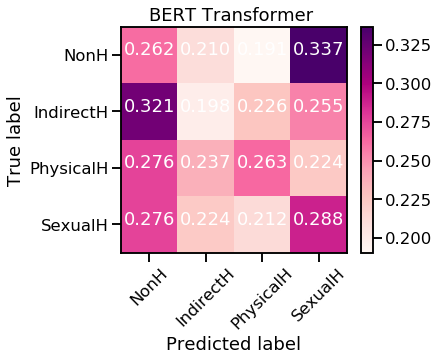

Test_ acc: 0.2633066415449835
Test_ f1 none: [0.387 0.075 0.08  0.192]
Test_ f1 macro: 0.18370428674010297
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.159 	F-macro_val: 0.115
Epoch 10 	acc_val: 0.335 	F-macro_val: 0.204
Epoch 20 	acc_val: 0.367 	F-macro_val: 0.220
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


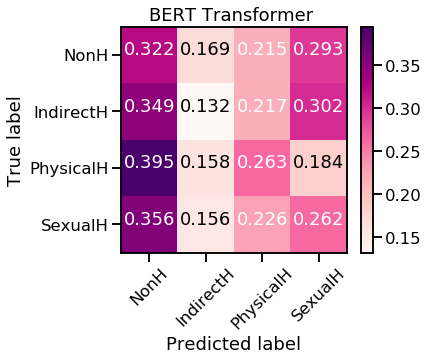

Test_ acc: 0.30098916627414035
Test_ f1 none: [0.448 0.061 0.074 0.189]
Test_ f1 macro: 0.19290558173965255
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.303 	F-macro_val: 0.184
Epoch 10 	acc_val: 0.259 	F-macro_val: 0.166
Epoch 20 	acc_val: 0.323 	F-macro_val: 0.195
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


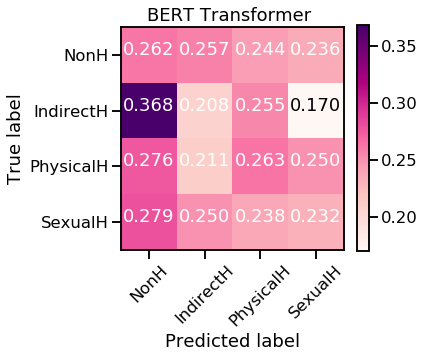

Test_ acc: 0.25482807348092323
Test_ f1 none: [0.386 0.069 0.067 0.189]
Test_ f1 macro: 0.1778368723694598
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.232 	F-macro_val: 0.157
Epoch 10 	acc_val: 0.323 	F-macro_val: 0.193
Epoch 20 	acc_val: 0.335 	F-macro_val: 0.199
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


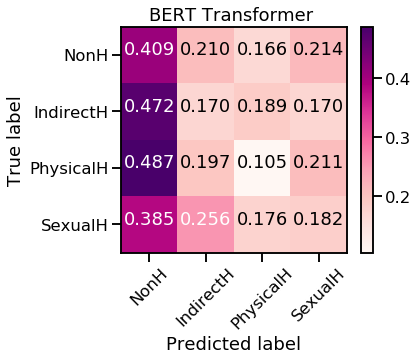

Test_ acc: 0.3499764484220443
Test_ f1 none: [0.53  0.064 0.037 0.159]
Test_ f1 macro: 0.19745944232812598
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.263 	F-macro_val: 0.162
Epoch 10 	acc_val: 0.288 	F-macro_val: 0.184
Epoch 20 	acc_val: 0.370 	F-macro_val: 0.219
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


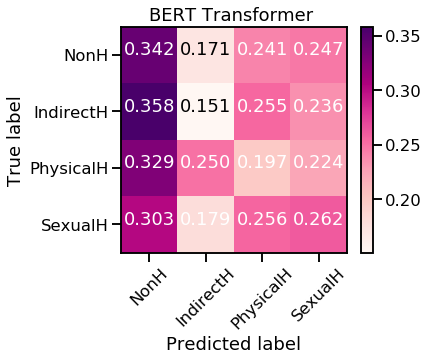

Test_ acc: 0.3141780499293453
Test_ f1 none: [0.473 0.067 0.051 0.206]
Test_ f1 macro: 0.19911174603507004
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.187 	F-macro_val: 0.136
Epoch 10 	acc_val: 0.295 	F-macro_val: 0.192
Epoch 20 	acc_val: 0.317 	F-macro_val: 0.195


In [ ]:
best_50, all_accs_50, all_fno_50, all_ma_50, all_cm_50 = train_transformer(0.5, 26, path_a, path_m, "RdPu", augmented=True)

In [31]:
print ("best_50", best_50)
print ("all_accs_50", all_accs_50)
print ("all_fno_50", all_fno_50)
print ("all_ma_50", all_ma_50)

best_50 {'F_ma': 0.22180074749063083, 'Run': 2}
all_accs_50 [0.28685821950070656, 0.3871879415920867, 0.3344324069712671, 0.3410268487988695, 0.39095619406500237, 0.2633066415449835, 0.30098916627414035, 0.25482807348092323, 0.3499764484220443, 0.3141780499293453, 0.2896844088553933, 0.3235986811116345, 0.3235986811116345, 0.3052284503061705, 0.2948657560056524, 0.33113518605746584, 0.33254828073480924, 0.33867169100329725, 0.33961375412152617, 0.3452661328308997]
all_fno_50 [array([0.417, 0.066, 0.047, 0.234]), array([0.56 , 0.08 , 0.076, 0.171]), array([0.487, 0.081, 0.059, 0.204]), array([0.5  , 0.092, 0.064, 0.179]), array([0.581, 0.078, 0.032, 0.129]), array([0.387, 0.075, 0.08 , 0.192]), array([0.448, 0.061, 0.074, 0.189]), array([0.386, 0.069, 0.067, 0.189]), array([0.53 , 0.064, 0.037, 0.159]), array([0.473, 0.067, 0.051, 0.206]), array([0.439, 0.101, 0.079, 0.168]), array([0.472, 0.099, 0.057, 0.216]), array([0.495, 0.067, 0.074, 0.154]), array([0.463, 0.118, 0.046, 0.159]), a

Acc: 0.322 -- deviation: 0.034
F-score: 0.200 -- deviation: 0.010
(0.5) NIPS: 0.4793908043775884 0.07894008025481454 0.058140287711367075 0.18406477309748506


Confusion counts
[[11358.  6385.  6203.  8074.]
 [  770.   426.   425.   499.]
 [  554.   312.   289.   365.]
 [ 2454.  1409.  1321.  1616.]]


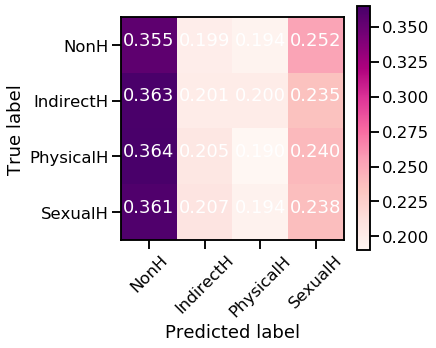

In [32]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_50)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_50)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_50)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_50)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_50)[:,0])
den=np.mean(np.asarray(all_fno_50)[:,1])
que=np.mean(np.asarray(all_fno_50)[:,2])
com=np.mean(np.asarray(all_fno_50)[:,3])

print ("(0.5) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_50:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='RdPu')

## 0.85 -- 10 run

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.234 	F-macro_val: 0.156
Epoch 10 	acc_val: 0.350 	F-macro_val: 0.198
Epoch 20 	acc_val: 0.285 	F-macro_val: 0.184
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


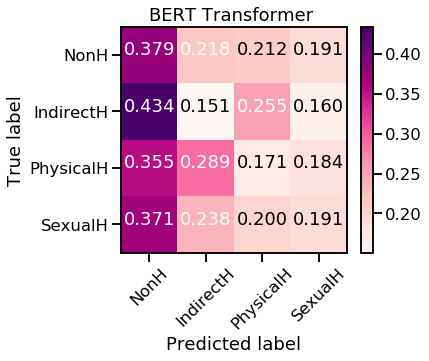

Test_ acc: 0.3301931229392369
Test_ f1 none: [0.504 0.056 0.05  0.175]
Test_ f1 macro: 0.1962566887659265


Nuevo best encontrado:

Acc: 0.330 	F1-ma: 0.196
	F1-none:  [0.504 0.056 0.05  0.175]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.254 	F-macro_val: 0.163
Epoch 10 	acc_val: 0.310 	F-macro_val: 0.188
Epoch 20 	acc_val: 0.381 	F-macro_val: 0.216
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


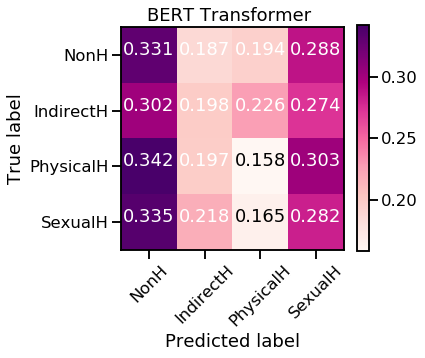

Test_ acc: 0.3104097974564296
Test_ f1 none: [0.46  0.082 0.05  0.202]
Test_ f1 macro: 0.1985613064939901


Nuevo best encontrado:

Acc: 0.310 	F1-ma: 0.199
	F1-none:  [0.46  0.082 0.05  0.202]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.294 	F-macro_val: 0.175
Epoch 10 	acc_val: 0.345 	F-macro_val: 0.207
Epoch 20 	acc_val: 0.349 	F-macro_val: 0.202
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


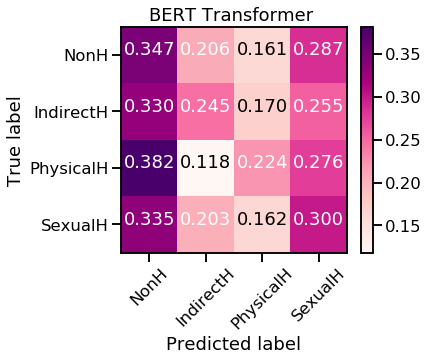

Test_ acc: 0.3297220913801225
Test_ f1 none: [0.476 0.096 0.08  0.215]
Test_ f1 macro: 0.2168040180324217


Nuevo best encontrado:

Acc: 0.330 	F1-ma: 0.217
	F1-none:  [0.476 0.096 0.08  0.215]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.283 	F-macro_val: 0.170
Epoch 10 	acc_val: 0.326 	F-macro_val: 0.198
Epoch 20 	acc_val: 0.385 	F-macro_val: 0.214
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


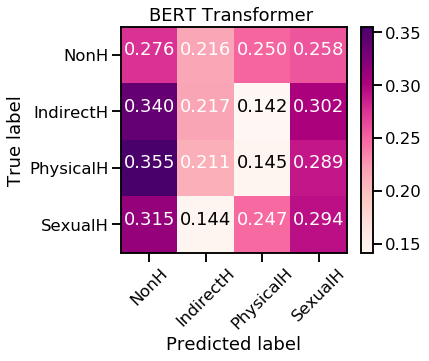

Test_ acc: 0.27131417804992936
Test_ f1 none: [0.399 0.085 0.038 0.221]
Test_ f1 macro: 0.1856731908613076
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.242 	F-macro_val: 0.162
Epoch 10 	acc_val: 0.341 	F-macro_val: 0.201
Epoch 20 	acc_val: 0.351 	F-macro_val: 0.209
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


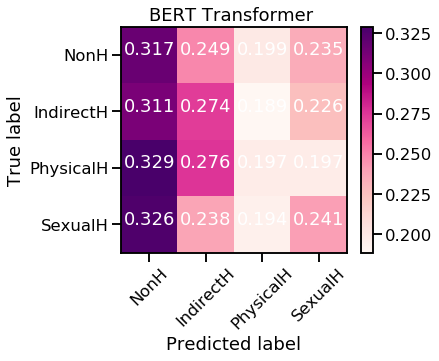

Test_ acc: 0.2986340084785681
Test_ f1 none: [0.446 0.091 0.06  0.196]
Test_ f1 macro: 0.1984413986952222
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.299 	F-macro_val: 0.178
Epoch 10 	acc_val: 0.257 	F-macro_val: 0.168
Epoch 20 	acc_val: 0.396 	F-macro_val: 0.218
Testing run # 6
SE TUVIERON QUE REPETIR 21 EJEMPLOS


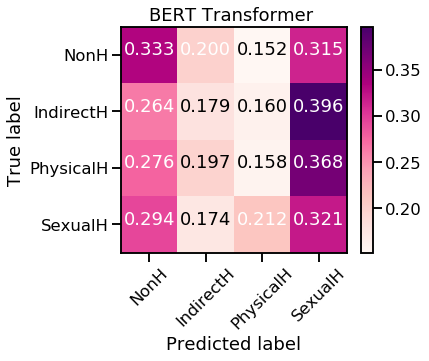

Test_ acc: 0.31700423928403204
Test_ f1 none: [0.467 0.073 0.057 0.213]
Test_ f1 macro: 0.20256326506785943
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.290 	F-macro_val: 0.176
Epoch 10 	acc_val: 0.323 	F-macro_val: 0.194
Epoch 20 	acc_val: 0.345 	F-macro_val: 0.208
Testing run # 7
SE TUVIERON QUE REPETIR 21 EJEMPLOS


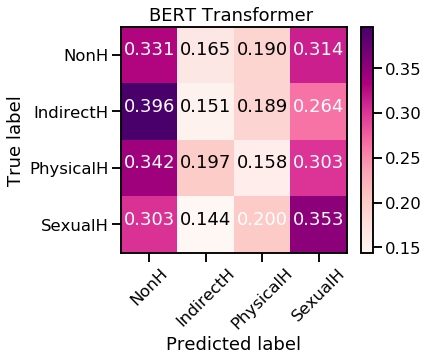

Test_ acc: 0.3193593970796043
Test_ f1 none: [0.46  0.071 0.05  0.237]
Test_ f1 macro: 0.2045666647245542
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.259 	F-macro_val: 0.164
Epoch 10 	acc_val: 0.281 	F-macro_val: 0.176
Epoch 20 	acc_val: 0.312 	F-macro_val: 0.192
Testing run # 8
SE TUVIERON QUE REPETIR 21 EJEMPLOS


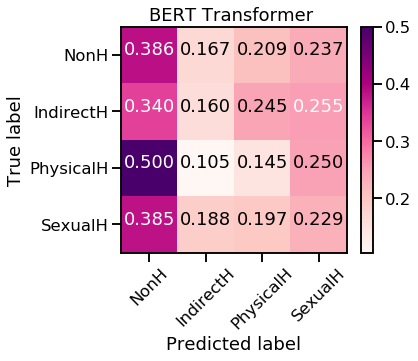

Test_ acc: 0.3410268487988695
Test_ f1 none: [0.51  0.073 0.043 0.185]
Test_ f1 macro: 0.2027219212984197
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.229 	F-macro_val: 0.157
Epoch 10 	acc_val: 0.260 	F-macro_val: 0.175
Epoch 20 	acc_val: 0.375 	F-macro_val: 0.217
Testing run # 9
SE TUVIERON QUE REPETIR 21 EJEMPLOS


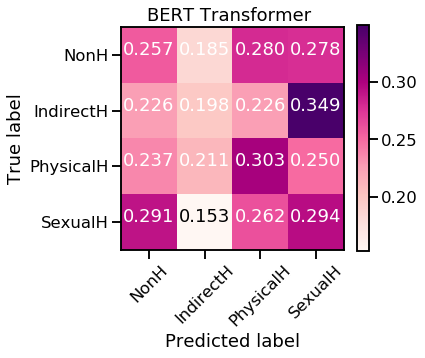

Test_ acc: 0.26189354686764016
Test_ f1 none: [0.383 0.086 0.07  0.213]
Test_ f1 macro: 0.1875801599448157
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.237 	F-macro_val: 0.156
Epoch 10 	acc_val: 0.339 	F-macro_val: 0.205
Epoch 20 	acc_val: 0.299 	F-macro_val: 0.189
Testing run # 10
SE TUVIERON QUE REPETIR 21 EJEMPLOS


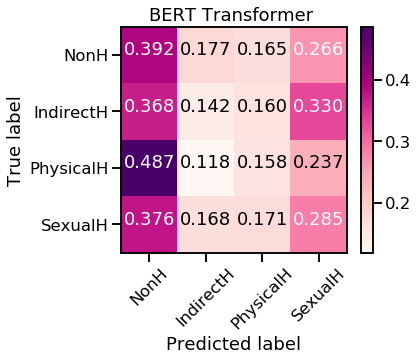

Test_ acc: 0.35374470089495996
Test_ f1 none: [0.516 0.064 0.056 0.212]
Test_ f1 macro: 0.21182893738049957


In [33]:
### solo 10!! 
best_85, all_accs_85, all_fno_85, all_ma_85, all_cm_85 =train_transformer(0.85, 26, path_a, path_m, "RdPu", xfrom=1, xto=10, augmented=True)

In [34]:
print ("best_85", best_85)
print ("all_accs_85", all_accs_85)
print ("all_fno_85", all_fno_85)
print ("all_ma_85", all_ma_85)

best_85 {'F_ma': 0.2168040180324217, 'Run': 3}
all_accs_85 [0.3301931229392369, 0.3104097974564296, 0.3297220913801225, 0.27131417804992936, 0.2986340084785681, 0.31700423928403204, 0.3193593970796043, 0.3410268487988695, 0.26189354686764016, 0.35374470089495996]
all_fno_85 [array([0.504, 0.056, 0.05 , 0.175]), array([0.46 , 0.082, 0.05 , 0.202]), array([0.476, 0.096, 0.08 , 0.215]), array([0.399, 0.085, 0.038, 0.221]), array([0.446, 0.091, 0.06 , 0.196]), array([0.467, 0.073, 0.057, 0.213]), array([0.46 , 0.071, 0.05 , 0.237]), array([0.51 , 0.073, 0.043, 0.185]), array([0.383, 0.086, 0.07 , 0.213]), array([0.516, 0.064, 0.056, 0.212])]
all_ma_85 [0.1962566887659265, 0.1985613064939901, 0.2168040180324217, 0.1856731908613076, 0.1984413986952222, 0.20256326506785943, 0.2045666647245542, 0.2027219212984197, 0.1875801599448157, 0.21182893738049957]


Acc: 0.313 -- deviation: 0.028
F-score: 0.200 -- deviation: 0.009
(0.85) NIPS: 0.4621141644473264 0.07771195362983072 0.0553850992107668 0.20678780321808282


Confusion counts
[[5362. 3154. 3221. 4273.]
 [ 351.  203.  208.  298.]
 [ 274.  146.  138.  202.]
 [1133.  635.  683.  949.]]


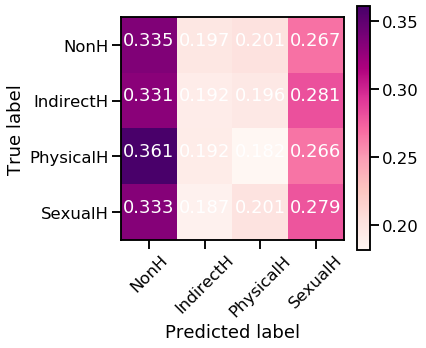

In [35]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_85)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_85)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_85)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_85)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_85)[:,0])
den=np.mean(np.asarray(all_fno_85)[:,1])
que=np.mean(np.asarray(all_fno_85)[:,2])
com=np.mean(np.asarray(all_fno_85)[:,3])

print ("(0.85) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_85:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='RdPu')